In [1]:
import torch
import pandas as pd
import numpy as np
import yaml
import importlib
import sys
import os
import matplotlib.pyplot as plt
import glob
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
stf_dir = os.path.join(os.pardir, 'spacetimeformer')

sys.path.append(stf_dir)


import spacetimeformer as stf
importlib.reload(stf) #to make sure the last version of stf is used

from torch.distributions import Normal
import pickle

In [2]:
os.listdir("..\\spacetimeformer\\spacetimeformer\\data\\stf_LOG_DIR\\wandb\\")

['run-20220105_151024-3debir7d',
 'run-20220105_151101-1xscb9t0',
 'run-20220105_151253-2r2wxfyk',
 'run-20220105_151410-jq1vxkvy',
 'run-20220105_152646-kvhj5avn',
 'run-20220105_152717-195gu43e',
 'run-20220105_153557-2x7jrlc3',
 'run-20220105_175945-3cp6v8qa',
 'run-20220105_180110-16s5ctwa',
 'run-20220105_180140-1kdcjqqi',
 'run-20220106_155935-1n5ojp36',
 'run-20220106_160201-20aekiwm',
 'run-20220106_160653-1gos8qq4',
 'run-20220106_160748-3cptxz9c',
 'run-20220107_105046-3m48jgg1',
 'run-20220107_123224-1klbw7yl',
 'run-20220107_123338-3dle75sx',
 'run-20220107_123609-3gofud6i',
 'run-20220107_123914-2rqfsrdy',
 'run-20220107_125914-rg87v0mq',
 'run-20220107_131635-2m8lgxsm',
 'run-20220107_134434-3aedj03h',
 'run-20220107_134448-uwacre6k',
 'run-20220107_140119-374fya35',
 'run-20220107_142345-3copmedt',
 'run-20220107_144028-x9zjly28',
 'run-20220107_144401-wyd4iko3',
 'run-20220107_151029-zkzb1nm9',
 'run-20220107_153324-2e62h1kx',
 'run-20220107_164217-1yc6io4a',
 'run-2022

In [3]:
run_name =    'run-20220315_103139-2kfujejz'
config_path = "..\\spacetimeformer\\spacetimeformer\\data\\stf_LOG_DIR\\wandb\\" + run_name+"\\files\\config.yaml"
with open(config_path) as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    config = yaml.load(file, Loader=yaml.FullLoader)
config_pross = {}
for key in config:
    try:
        config_pross[key]=config[key]['value']
    except:
        config_pross[key]=config[key]
config=config_pross
print(config['run_name'])

rerun_best_HFint


In [6]:
#build the dset
if config['dset'] =='AquaCTD':
    data_path = config['data_path']
    date_format = "%d-%m-%Y"
    if data_path == 'auto':
        data_path = "../Datasets/Forecasting_Aqua/ctd_meteo_aua_2019to2021_V2.csv"
    df = pd.read_csv(data_path)
    target_cols = ['mean_chla']
    target_cols+=list(df.keys().drop(['Datetime','mean_chla']))
    NULL_VAL = 0.
if config['dset']=='small_aqua':
    data_path = config['data_path']
    date_format = "%d/%m/%Y"
    if data_path == 'auto':
        data_path = "../Datasets/Forecasting_Aqua/ctd_meteo_aua_2019to2021_small_V2.csv"
    df = pd.read_csv(data_path)
    target_cols = ['mean_chla']
    target_cols+=list(df.keys().drop(['Datetime','mean_chla']))
    NULL_VAL = 0.
if config['dset']=='vsmall_aqua':
    data_path = config['data_path']
    date_format = "%d/%m/%Y"
    if data_path == 'auto':
        data_path = "../Datasets/Forecasting_Aqua/ctd_meteo_aua_2019to2021_vsmall_toy.csv"
    df = pd.read_csv(data_path)
    target_cols = []
    target_cols+=list(df.keys().drop(['Datetime']))
    NULL_VAL = 0.
if config['dset'] =='HF_int':
        data_path = config['data_path']
        date_format = "%Y-%m-%d %H:%M:%S"
        if data_path == 'auto':
            data_path = "../Datasets/Forecasting_Aqua/data_h_rolling_interpolated.csv"
        df = pd.read_csv(data_path)
        target_cols = ['mean_chla_depth']
        target_cols+=list(df.keys().drop(['Datetime','mean_chla_depth']))
        NULL_VAL = 0.  
if 'small_HF' in config['dset']:
    data_path = config['data_path']
    date_format = "%d/%m/%Y %H:%M"
    if data_path == 'auto':
        if config['dset'] == 'small_HF_int':
            data_path = "../Datasets/Forecasting_Aqua/data_h_rolling_interpolated_small.csv"
        elif config['dset'] == 'small_HF_noint':
            data_path = "../Datasets/Forecasting_Aqua/data_h_rolling_small.csv"
    df = pd.read_csv(data_path)
    target_cols = ['mean_chla_depth']
    target_cols+=list(df.keys().drop(['Datetime','mean_chla_depth']))
    NULL_VAL = 0.  

dset = stf.data.CSVTimeSeries(
    data_path=data_path,
    target_cols=target_cols,
    date_format = date_format,
    nanval = NULL_VAL,
)
x_dim = 4 if config['dset'] =='HF_int' else 3
y_dim = len(target_cols)
loss_w = torch.zeros(y_dim)
loss_w[0] = 1
loss_w /=loss_w.sum()

#build the model
if config['model'] =='spacetimeformer':
    forecaster = stf.spacetimeformer_model.Spacetimeformer_Forecaster(
            d_y=y_dim,
            d_x=x_dim,
            start_token_len=config['start_token_len'],
            attn_factor=config['attn_factor'],
            d_model=config['d_model'],
            n_heads=config['n_heads'],
            e_layers=config['enc_layers'],
            d_layers=config['dec_layers'],
            d_ff=config['d_ff'],
            dropout_emb=config['dropout_emb'],
            dropout_token=config['dropout_token'],
            dropout_attn_out=config['dropout_attn_out'],
            dropout_qkv=config['dropout_qkv'],
            dropout_ff=config['dropout_ff'],
            global_self_attn=config['global_self_attn'],
            local_self_attn=config['local_self_attn'],
            global_cross_attn=config['global_cross_attn'],
            local_cross_attn=config['local_cross_attn'],
            performer_kernel=config['performer_kernel'],
            performer_redraw_interval=config['performer_redraw_interval'],
            post_norm=config['post_norm'],
            norm=config['norm'],
            activation=config['activation'],
            init_lr=config['init_lr'],
            base_lr=config['base_lr'],
            warmup_steps=config['warmup_steps'],
            decay_factor=config['decay_factor'],
            initial_downsample_convs=config['initial_downsample_convs'],
            intermediate_downsample_convs=config['intermediate_downsample_convs'],
            embed_method=config['embed_method'],
            l2_coeff=config['l2_coeff'],
            loss=config['loss'],
            linear_window=config['linear_window'],
            class_loss_imp=config['class_loss_imp'],
            time_emb_dim=config['time_emb_dim'],
            loss_weight= loss_w
        )
elif config['model'] == "lstm":
    forecaster = stf.lstm_model.LSTM_Forecaster(
        # encoder
        d_x=x_dim,
        d_y=y_dim,
        time_emb_dim=config['time_emb_dim'],
        hidden_dim=config['hidden_dim'],
        n_layers=config['n_layers'],
        dropout_p=config['dropout_p'],
        # training
        learning_rate=config['learning_rate'],
        teacher_forcing_prob=config['teacher_forcing_start'],
        l2_coeff=config['l2_coeff'],
        loss=config['loss'],
        linear_window=config['linear_window'],
    )
if config['model']=='LTC':
    print("not implemented")


AssertionError: 

In [303]:
#load the checkpoints
checkpoints_dir = "..\\spacetimeformer\\data\\stf_model_checkpoints\\"
run_name = config['run_name']
salt = ""

checkpoints = glob.glob(checkpoints_dir+run_name+"_"+salt+"*\\*\\*",recursive=True)
if len(checkpoints)>1:
    print("please add a part of the random number so there is only one result")
checkpoint = checkpoints[0]
checkpoints

['..\\spacetimeformer\\data\\stf_model_checkpoints\\rerun_best_sweep_449689925\\rerun_best_sweepepoch=10-val\\loss=0.61.ckpt']

In [304]:
config['model']

'lstm'

In [305]:
forecaster.load_state_dict(torch.load(checkpoint)['state_dict'],strict=True)

<All keys matched successfully>

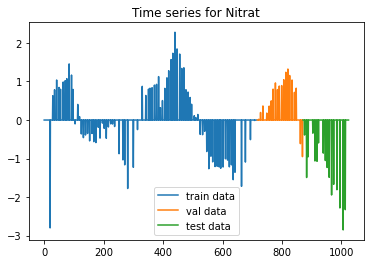

In [306]:
key = 'Nitrat'
y_train = dset.train_data[key]
y_val = dset.val_data[key]
y_test = dset.test_data[key]
plt.plot(dset.train_data.index,y_train)
plt.plot(dset.val_data.index,y_val)
plt.plot(dset.test_data.index,y_test)
plt.title(f"Time series for {key}")
plt.legend(["train data","val data","test data"])
plt.show()

In [307]:
dset.val_data['Nitrat']

717    0.000000
718    0.000000
719    0.000000
720    0.000000
721    0.000000
         ...   
866    0.000000
867    0.000000
868    0.000000
869   -0.950598
870    0.000000
Name: Nitrat, Length: 154, dtype: float64

In [308]:
#format the dataset into x and y:
x_train = (dset.train_data[['Day','Month','Year','Hour']] if config['dset'] =='HF_int'
           else dset.train_data[['Day','Month','Year']])
y_train = dset.train_data[target_cols]

x_val = (dset.val_data[['Day','Month','Year','Hour']] if config['dset'] =='HF_int'
        else dset.val_data[['Day','Month','Year']])
y_val = dset.val_data[target_cols]

x_test = (dset.test_data[['Day','Month','Year','Hour']] if config['dset'] =='HF_int'
          else dset.test_data[['Day','Month','Year']])
y_test = dset.test_data[target_cols]

As one can see, some keys like cluster_7 needs strong extrapolation capabilities, as some events are only present in test data.
This visualisation makes it also clear why the validation score of the mean_chla was systematically worse than its test score: the test data is closer to the training data than the validation 

In [310]:
idx = 0
ctx = config['context_points']
trg = config['target_points']
x = torch.tensor(x_train.values,dtype=torch.float32)
y = torch.tensor(y_train.values,dtype=torch.float32)
res_idx,*class_res=forecaster(x[idx:idx+ctx].unsqueeze(0),
                              y[idx:idx+ctx].unsqueeze(0),
                              x[idx+ctx:idx+ctx+trg].unsqueeze(0),
                              y[idx+ctx:idx+ctx+trg].unsqueeze(0),
                      **forecaster.eval_step_forward_kwargs)

In [311]:
if isinstance(res_idx,torch.distributions.Normal):
    plt.plot(range(config['context_points'],config['context_points']+config['target_points']),
             res_idx.loc[0,:,0].detach().numpy())
    plt.plot(range(config['context_points'],config['context_points']+config['target_points']),
             split_dset[idx][3][:,0])
    plt.plot(range(config['context_points']),split_dset[idx][1][:,0])

In [18]:
#predict all results
res = {}
ctx = config['context_points']
trg = config['target_points']

for x,y,split in [(x_train,y_train,'train'),(x_val,y_val,'val'),(x_test,y_test,'test')]:
    x = torch.tensor(x.values,dtype=torch.float32)
    y = torch.tensor(y.values,dtype=torch.float32)
    res[split]=[]
    print(f"split: {split}")
    for idx in range(len(x)-ctx-trg):
        print(idx,end='\r')
        with torch.no_grad():

            res_idx,*class_res=forecaster(x[idx:idx+ctx].unsqueeze(0),
                                          y[idx:idx+ctx].unsqueeze(0),
                                          x[idx+ctx:idx+ctx+trg].unsqueeze(0),
                                          y[idx+ctx:idx+ctx+trg].unsqueeze(0),
                                  **forecaster.eval_step_forward_kwargs)
            if isinstance(res_idx,Normal):
                res[split].append(res_idx.loc.squeeze())
            else:
                res[split].append(res_idx.squeeze())


split: train
split: val
split: test


In [19]:
pred_training = torch.stack(res['train'])
pred_val = torch.stack(res['val'])
pred_test = torch.stack(res['test'])

In [20]:
df.keys()

Index(['Datetime', 'nauplius', 'ciliate', 'mean_temp', 'mean_o2', 'mean_ph',
       'mean_chla', 'cv_chla_day', 'precipitation_tot', 'windspeed_max',
       'Nitrat', 'Nitrit', 'Ammonium', 'TP', 'TN', 'mean_thermocline_depth',
       'mean_schmidt', 'mean_mixed_layer_depth'],
      dtype='object')

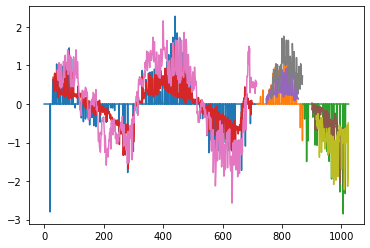

In [151]:
#for key in df.keys().drop(['Datetime']):
key = "Nitrat"
#key = "mean_condF"
lag = 1


idx = target_cols.index(key)
ctx = config['context_points']
lag -=1


plt.plot(dset.train_data[key])
plt.plot(dset.val_data[key])
plt.plot(dset.test_data[key])

plt.plot(range(lag+ctx,lag+ctx+len(pred_training)),pred_training[:,lag,idx])
plt.plot((dset.val_data[key].index+lag+ctx)[:len(pred_val)],pred_val[:,lag,idx])
plt.plot((dset.test_data[key].index+lag+ctx)[:len(pred_test)],pred_test[:,lag,idx])



lag+=14
plt.plot(range(lag+ctx,lag+ctx+len(pred_training)),pred_training[:,lag,idx])
plt.plot((dset.val_data[key].index+lag+ctx)[:len(pred_val)],pred_val[:,lag,idx])
plt.plot((dset.test_data[key].index+lag+ctx)[:len(pred_test)],pred_test[:,lag,idx])



plt.show()

In [165]:
max_lag = 15

R2ar = np.zeros((3,max_lag,len(df.keys())-1))
for idx_split,split in enumerate(['train','val','test']):
    if split == 'train':
        data = dset.train_data.reset_index().replace(0,np.nan)
        pred = pred_training
    if split == 'val':
        data = dset.val_data.reset_index().replace(0,np.nan)
        pred = pred_val
    if split == 'test':
        pred = pred_test
        data = dset.test_data.reset_index().replace(0,np.nan)
    data_ar = data.drop(columns=['Datetime']).to_numpy()
    mask = data_ar != 0.
    for lag in range(1,16):
        for key in df.keys().drop(['Datetime']):
            idx = target_cols.index(key)

            R2 = (1-np.mean(np.square(mask[ctx+lag-1:-trg+lag-1,idx]*(data[key][ctx+lag-1:-trg+lag-1]-pred[:,lag-1,idx].numpy())))/
                    np.mean(np.square(mask[ctx+lag-1:-trg+lag-1,idx]*(data[key][ctx+lag-1:-trg+lag-1]-data[key][ctx+lag-1:-trg+lag-1].mean()))))
            R2ar[idx_split,lag-1,idx]=R2

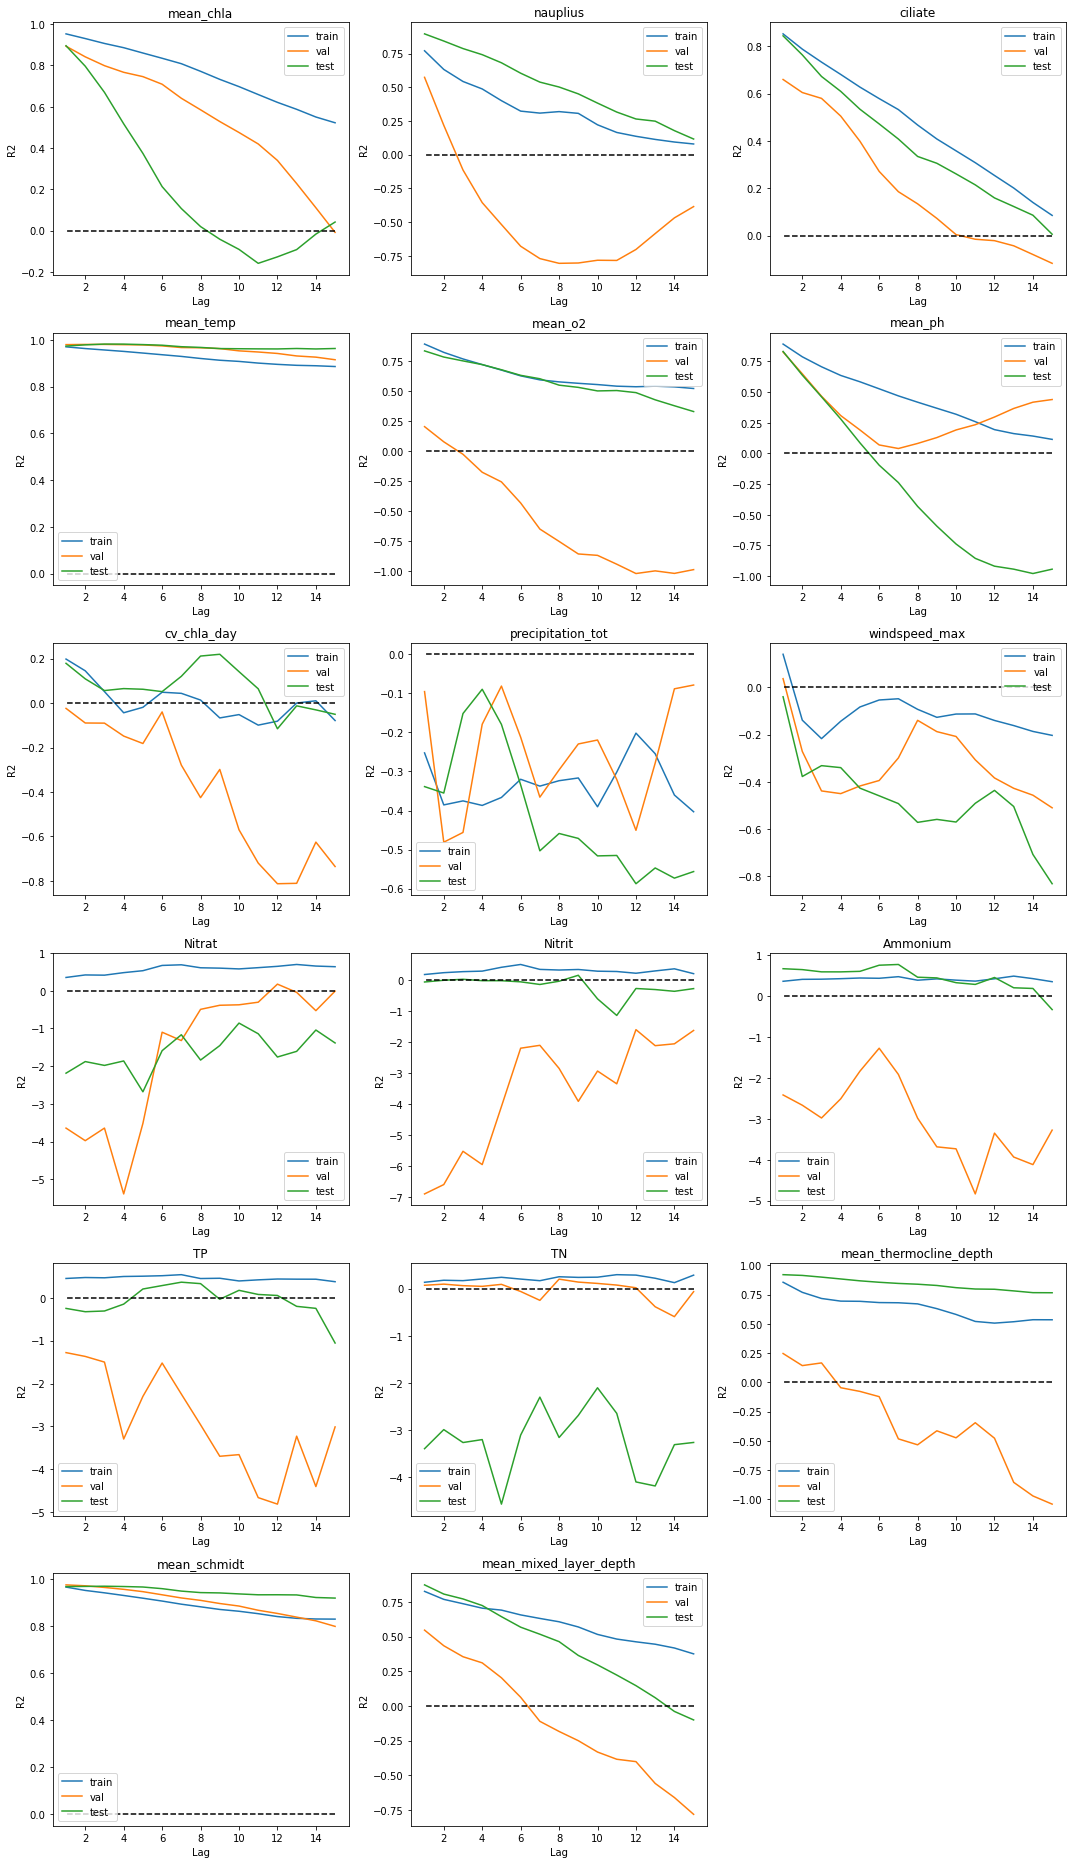

In [252]:
key = 'mean_chla'
n_plots = len(target_cols)
fig,axt = plt.subplots(1+n_plots//3,3,figsize=(15,4+4*n_plots//3),tight_layout = True)
axs = np.ravel(axt)
for ax,key in zip(axs,target_cols):
    idx = target_cols.index(key)
    [ax.plot(range(1,max_lag+1),R2ar[idx_split,:,idx]) for idx_split in range(3)]
    ax.legend(['train','val','test'])
    ax.hlines(0,max_lag,1,linestyle='dashed',color='black')
    ax.set_ylabel("R2")
    ax.set_xlabel("Lag")
    ax.set_title(key)
for delete_idx in range(-3+(n_plots)%3,0):
    axt[-1,delete_idx].set_axis_off()
plt.show()

# Animation

In [319]:
plt_key = 'precipitation_tot'


fig,ax = plt.subplots(1,1,figsize=(10,6))
lag = 0
idx = target_cols.index(plt_key)
ctx = config['context_points']

ax.plot(dset.train_data[plt_key])
ax.plot(dset.val_data[plt_key])
ax.plot(dset.test_data[plt_key])

pl_train = ax.plot(range(lag+ctx,lag+ctx+len(pred_training)),pred_training[:,lag,idx])
pl_val = ax.plot((dset.val_data[plt_key].index+lag+ctx)[:len(pred_val)],pred_val[:,lag,idx])
pl_test = ax.plot((dset.test_data[plt_key].index+lag+ctx)[:len(pred_test)],pred_test[:,lag,idx])

title = ax.set_title(f"Prediction with a lag of {lag+1} days")
ax.set_xlabel('relative date [day]')
ax.set_ylabel(f'scaled {plt_key}')
plt.close(fig)

In [320]:
def animate(lag):
    #set_x
    pl_train[0].set_xdata(range(lag+ctx,lag+ctx+len(pred_training)))
    pl_val[0].set_xdata((dset.val_data[plt_key].index+lag+ctx)[:len(pred_val)])
    pl_test[0].set_xdata((dset.test_data[plt_key].index+lag+ctx)[:len(pred_test)])
    #set_y
    pl_train[0].set_ydata(pred_training[:,lag,idx])
    pl_val[0].set_ydata(pred_val[:,lag,idx])
    pl_test[0].set_ydata(pred_test[:,lag,idx])
    
    
    title.set_text(f"Prediction with a lag of {lag+1} days")
    return [pl_train,pl_val,pl_test,title]
ani = FuncAnimation(
    fig, animate,frames = range(0,15), blit=False, save_count=50)

plt.close(fig)

HTML(ani.to_jshtml())

# Attention matrix:


In [290]:
forecaster.eval_step_forward_kwargs['output_attn'] = True

In [299]:
idx = 0
ctx = config['context_points']
trg = config['target_points']
x = torch.tensor(x_train.values,dtype=torch.float32)
y = torch.tensor(y_train.values,dtype=torch.float32)
res_idx,(logist,labels),attention_mat=forecaster.forward_model_pass(x[idx:idx+ctx].unsqueeze(0),
                              y[idx:idx+ctx].unsqueeze(0),
                              x[idx+ctx:idx+ctx+trg].unsqueeze(0),
                              y[idx+ctx:idx+ctx+trg].unsqueeze(0),
                              output_attn=True)

In [305]:
attn = attention_mat[0][0]

In [315]:
ath = attn[0]

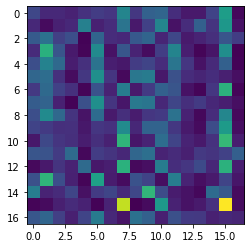

In [338]:
#sum all time steps
ath_s = np.zeros((attn.shape[0],len(target_cols),len(target_cols)))
for num_head in range(attn.shape[0]):
    for idx1 in range(len(target_cols)):
        for idx2 in range(len(target_cols)):
            ath_s[num_head,idx1,idx2]=torch.sum(attn[num_head,ctx*idx1:ctx*(idx1+1),ctx*idx2:ctx*(idx2+1)])
plt.imshow(ath_s[0])

In [341]:
#build an adcacency matrix from the sum of all heads:
adj = np.sum(ath_s,axis=0)

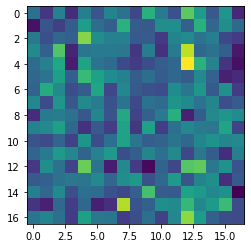

In [342]:
plt.imshow(adj)

In [351]:
#pickle the adjacency matrix to use in the graph notebook
file_att = 'adj_att.pickle'
with open(file_att, 'wb') as f:
    pickle.dump(adj, f)
file_name = 'name.pickle'
with open(file_name, 'wb') as f:
    pickle.dump(target_cols, f)